In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")

df = pd.read_csv('Group_20_data_cleaned.csv')
df.drop('Unnamed: 0', axis = 1 , inplace = True)
df["Letter"] = pd.factorize(df['Letter'])[0]

In [2]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import pandas as pd


In [4]:
def stepwise_selection(data, target, SL_in=0.05, SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []

    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)

        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()

        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())

            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()

                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)

                else:
                    break 

        else:
            break

    return best_features

In [5]:
import pandas as pd

X = df.drop("Letter", 1)       # feature matrix
y = df['Letter']               # target feature

In [6]:
features = list(X.columns)
print(features)

['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y_ege', 'yegvx']


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

bde_features = stepwise_selection(X,y)
print(bde_features)

['x2ybr', 'xy2br', 'x-bar', 'xegvy', 'y-bar', 'y_ege', 'yegvx', 'width', 'y-box', 'x-ege', 'y2bar', 'onpix', 'high', 'x2bar']


## Feature selection

In [8]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:,1:].to_numpy(), df.Letter.to_numpy()
bde_X, y = df.loc[:, bde_features].to_numpy(), df.Letter.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

bde_X_train, bde_X_test, y_train, y_test = train_test_split(bde_X, y, test_size=0.20, random_state=42)
bde_X_train, bde_X_val, y_train, y_val = train_test_split(bde_X_train, y_train, test_size=0.20, random_state=42)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

simple_knn_model = KNeighborsClassifier(n_neighbors=10,
                             weights="distance",
                             algorithm="auto")

simple_knn_model.fit(X_train, y_train)
print("Accuracy : {:.2f}%".format(simple_knn_model.score(X_val, y_val)*100))

Accuracy : 94.38%


In [10]:
from sklearn.neighbors import KNeighborsClassifier

bde_knn_model = KNeighborsClassifier(n_neighbors=10,
                             weights="distance",
                             algorithm="auto")

bde_knn_model.fit(bde_X_train, y_train)
print("Accuracy : {:.2f}%".format(bde_knn_model.score(bde_X_val, y_val)*100))

Accuracy : 93.47%


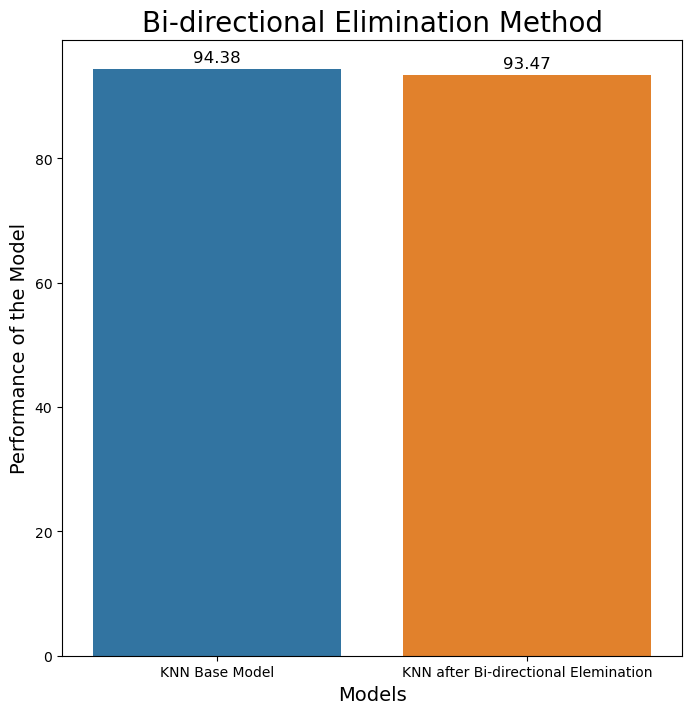

In [11]:
# Importing libraries for dataframe creation
# and graph plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_results = {"Model Names" : ["KNN Base Model",
                                      "KNN after Bi-directional Elemination",],
        "Accuracy": [simple_knn_model.score(X_val, y_val)*100,
                    bde_knn_model.score(bde_X_val, y_val)*100,]}
accuracy_results = pd.DataFrame(accuracy_results, columns=['Model Names', 'Accuracy'])

plt.figure(figsize=(8, 8))
plots = sns.barplot(x="Model Names", y="Accuracy", data=accuracy_results)

for bar in plots.patches:
  plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.title("Bi-directional Elimination Method", size=20)
plt.xlabel("Models", size=14, )
# plt.xticks(rotation = 25) 
plt.ylabel("Performance of the Model", size=14)
plt.show()

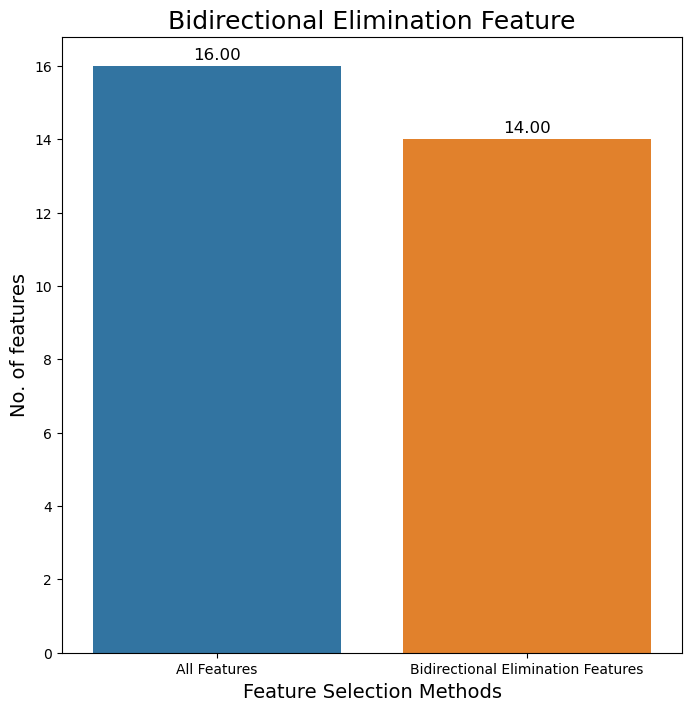

In [12]:
# Importing libraries for dataframe creation
# and graph plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_results = {"Model Names" : ['All Features', 'Bidirectional Elimination Features'],
        "Accuracy": [len(features), 
                     len(bde_features)]}
accuracy_results = pd.DataFrame(accuracy_results, columns=['Model Names', 'Accuracy'])
plt.figure(figsize=(8, 8))
plots = sns.barplot(x="Model Names", y="Accuracy", data=accuracy_results)
 
for bar in plots.patches:
     plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Feature Selection Methods", size=14)
plt.ylabel("No. of features", size=14)
plt.title("Bidirectional Elimination Feature", size=18)
plt.show()


In [13]:
print(features)
print(bde_features)

['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y_ege', 'yegvx']
['x2ybr', 'xy2br', 'x-bar', 'xegvy', 'y-bar', 'y_ege', 'yegvx', 'width', 'y-box', 'x-ege', 'y2bar', 'onpix', 'high', 'x2bar']


In [14]:
set(features)-set(bde_features)

{'x-box', 'xybar'}